In [11]:
#sudo apt-get install git-lfs
!pip install fastparquet

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 46.5 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 76.1 MB/s eta 0:00:00


In [1]:
%%capture
!pip install transformers torch
!pip install nltk
!pip install rouge-score

In [1]:
import torch
import gc
import pandas as pd
from IPython.display import Image
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
from torch.optim import AdamW
from transformers import AutoModelForCausalLM, AutoTokenizer

/home/insightlab/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Verificar se CUDA está disponível
if torch.cuda.is_available():
    print("CUDA está disponível. Usando GPU.")
    device = torch.device("cuda")
else:
    print("CUDA não está disponível. Usando CPU.")
    device = torch.device("cpu")

CUDA está disponível. Usando GPU.


In [9]:
!git clone https://github.com/paulinavelasquez/LLM---alpaca

Cloning into 'LLM---alpaca'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 12 (delta 1), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (12/12), 24.56 KiB | 0 bytes/s, done.
Resolving deltas: 100% (1/1), done.


# **INTRODUÇÃO**

Este notebook, consiste em utilizar e ajustar um LLM. Serão usados 1 dataset público e 1 modelo open-source.

De acordo com a estrutura do Dataset, o dataset está organizado da seguinte forma:

*   **Instruction:** Cada linha do dataset contém uma instrução específica que o modelo deve seguir.

*   **Input:** Algumas instruções vêm acompanhadas de um dado de entrada adicional, que fornece contexto ou informação que o modelo deve utilizar para executar a tarefa.

*   **Output:** Esta é a resposta ou resultado que se espera que o modelo gere com base na instrução e na entrada fornecida.

*   **Text:** Uma combinação dos campos anteriores em um único campo de texto, formatado para ser usado no ajuste fino de modelos.

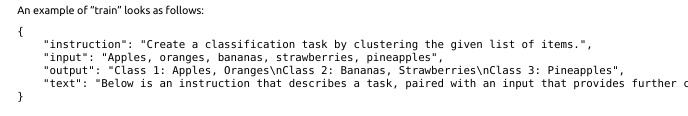

In [7]:
Image('/home/insightlab/Documents/Axur/LLM---alpaca/StructureAlpaca.png')

In [22]:
!git lfs install

Git LFS initialized.


In [23]:
!git clone https://huggingface.co/datasets/tatsu-lab/alpaca

Cloning into 'alpaca'...
remote: Enumerating objects: 26, done.
remote: Total 26 (delta 0), reused 0 (delta 0), pack-reused 26 (from 1)
Unpacking objects: 100% (26/26), 6.07 KiB | 1.52 MiB/s, done.


In [25]:
# Luego, navega al directorio clonado
%cd alpaca

/home/insightlab/Documents/Axur/alpaca


/home/insightlab/.local/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [26]:
!git lfs pull

In [27]:
!ls -lh

total 12K
drwxrwxr-x 2 insightlab insightlab 4,0K ago 20 08:40 data
-rw-rw-r-- 1 insightlab insightlab 7,3K ago 20 08:40 README.md


## Extração de partes do dataset com 5000 linhas cada. Uma das partes será o dataset de teste e a outra, o de treino.

In [3]:
# Ler o arquivo
df = pd.read_parquet("/home/insightlab/Documents/Axur/alpaca/data/train-00000-of-00001-a09b74b3ef9c3b56.parquet")
df

,instruction,input,output,text
0,Give three tips for staying healthy.,,1.Eat a balanced diet and make sure to include...,Below is an instruction that describes a task....
1,What are the three primary colors?,,"The three primary colors are red, blue, and ye...",Below is an instruction that describes a task....
2,Describe the structure of an atom.,,"An atom is made up of a nucleus, which contain...",Below is an instruction that describes a task....
3,How can we reduce air pollution?,,There are a number of ways to reduce air pollu...,Below is an instruction that describes a task....
4,Describe a time when you had to make a difficu...,,I had to make a difficult decision when I was ...,Below is an instruction that describes a task....
...,...,...,...,...
51997,Generate an example of what a resume should li...,,"Jean Tremaine\n1234 Main Street, Anytown, CA 9...",Below is an instruction that describes a task....
51998,Arrange the items given below in the order to ...,"cake, me, eating",I eating cake.,"Below is an instruction that describes a task,..."
51999,Write an introductory paragraph about a famous...,Michelle Obama,Michelle Obama is an inspirational woman who r...,"Below is an instruction that describes a task,..."
52000,Generate a list of five things one should keep...,,1. Research potential opportunities and carefu...,Below is an instruction that describes a task....


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52002 entries, 0 to 52001
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   instruction  52002 non-null  object
 1   input        52002 non-null  object
 2   output       52002 non-null  object
 3   text         52002 non-null  object
dtypes: object(4)
memory usage: 1.6+ MB


In [5]:
df.describe()

,instruction,input,output,text
count,52002,52002,52002,52002
unique,52002,19188,50842,52002
top,Give three tips for staying healthy.,,Negative,Below is an instruction that describes a task....
freq,1,31323,44,1


In [4]:
# Dividir o dataset nos primeiros 5000 exemplos para treino
train_dataset = df[:5000]

# Dividir o dataset nos próximos 5000 exemplos para teste
test_dataset = df[5000:10000]

# Verificar o tamanho dos novos datasets
print(f"Tamanho do dataset de treino: {len(train_dataset)}")
print(f"Tamanho do dataset de teste: {len(test_dataset)}")

Tamanho do dataset de treino: 5000
Tamanho do dataset de teste: 5000


In [7]:
# Carregar o modelo Qwen-1.5 e o tokenizer
model_name = "Qwen/Qwen1.5-1.8B"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)
# Mover o modelo para a GPU
model.to(device)

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 2048)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2SdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=True)
          (k_proj): Linear(in_features=2048, out_features=2048, bias=True)
          (v_proj): Linear(in_features=2048, out_features=2048, bias=True)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): Qwen2RotaryEmbedding()
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=2048, out_features=5504, bias=False)
          (up_proj): Linear(in_features=2048, out_features=5504, bias=False)
          (down_proj): Linear(in_features=5504, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((2048,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((2048,), eps=1e-06)
      )
    )
    (norm): 

# Execução das instruções da coluna "instruction" do dataset de teste.

In [34]:
# Função para gerar uma resposta usando o modelo Qwen-1.5
def generate_response_qwen(instruction, input_text):
    # Preparar o prompt combinando a instrução e o texto de entrada
    prompt = f"{instruction}\n{input_text}"

    # Tokenizar o prompt
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    #inputs = tokenizer(prompts, return_tensors="pt", padding=True, truncation=True).to(device)

    # Gerar a resposta usando o modelo na GPU
    outputs = model.generate(**inputs, max_length=150)

    # Decodificar a resposta gerada
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    #responses = [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]

    return response

# Aplicar o modelo Qwen-1.5 às instruções do dataset de teste
test_dataset['predicted_output'] = test_dataset.apply(
    lambda row: generate_response_qwen(row['instruction'], row['input']), axis=1)

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Both `max_new_tokens` (=2048) and `max_length`(=150) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Both `max_new_tokens` (=2048) and `max_length`(=150) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Both `max_new_tokens` (=2048) and `max_length`(=150) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `e

In [78]:
test_dataset[['instruction', 'input', 'predicted_output']].head()

,instruction,input,predicted_output
5000,Generate a chessboard with the given size and ...,Size: 8x8 \nPiece positions:\nWhite Rook at H8...,Generate a chessboard with the given size and ...
5001,Find a word in the sentence that is used as a ...,Sentence: She went to the store to buy some ap...,Find a word in the sentence that is used as a ...
5002,Write pseudocode for a Merge Sort algorithm.,,Write pseudocode for a Merge Sort algorithm.\n...
5003,Provide a evidence explaining why the followin...,"def add(a, b):\n return a + b",Provide a evidence explaining why the followin...
5004,Compare and contrast Object-Oriented Programmi...,,Compare and contrast Object-Oriented Programmi...


# Avaliação da qualidade do resultado
Para avaliar a calidade dos resultados gerados pelo modelo Qwen1.5-1.8B e se determine se as respotas estão corretas podemos seguir um emfoque estruturado:

In [36]:
for index, row in test_dataset.head(10).iterrows():
    print(f"Instrução: {row['instruction']}")
    print(f"Entrada: {row['input']}")
    print(f"Resposta Esperada: {row['output']}")
    print(f"Resposta Gerada: {row['predicted_output']}")
    print("-" * 50)

Instrução: Generate a chessboard with the given size and with pieces at the specified positions.
Entrada: Size: 8x8 
Piece positions:
White Rook at H8
White Pawn at B3
Black Pawn at A3
Black Rook at H2
Resposta Esperada: ![Image of 8x8 chessboard](https://i.imgur.com/G8HyAoo.png)
Resposta Gerada: Generate a chessboard with the given size and with pieces at the specified positions.
Size: 8x8 
Piece positions:
White Rook at H8
White Pawn at B3
Black Pawn at A3
Black Rook at H2
White Pawn at D3
White Bishop at C2
Black Pawn at B2
Black Bishop at D2
White Pawn at E8
White Queen at F8
White Pawn at G8
White Bishop at H8
Black Pawn at B3
Black Rook at A2
White Pawn at D3
White Pawn at E8
White Queen at F8
White Pawn at G8
White Bishop at H8
Black Pawn at B2
Black Bishop at D2
White Pawn at E8
White Queen at F8
White Pawn at G8
White Bishop at H8
Black Pawn at B3
Black Rook at A2
White Pawn at D3
White Pawn at E8
White Queen at F8
White Pawn at G8
White Bishop at H8
Black Pawn at B3
Black Roo

In [39]:
# Selecionar uma amostra aleatória de 10 respostas para avaliação manual
sample = test_dataset.sample(10)

# Lista para armazenar os resultados
results = []

# Iterar sobre a amostra e coletar as informações
for index, row in sample.iterrows():
    # Determinar se a resposta está correta ou incorreta
    correta = "Correta" if row['output'] == row['predicted_output'] else "Incorreta"
    
    # Adicionar os resultados a lista
    results.append({
        "Instrução": row['instruction'],
        "Entrada": row['input'],
        "Resposta Esperada": row['output'],
        "Resposta Gerada": row['predicted_output'],
        "Correta/Incorreta": correta
    })

# Converter a lista de resultados para um DataFrame
df_results_test = pd.DataFrame(results)
df_results_test

,Instrução,Entrada,Resposta Esperada,Resposta Gerada,Correta/Incorreta
0,Determine the most common word in the text.,"Humans are created in the image of God, from a...","The most common word in the text is ""the"".",Determine the most common word in the text.\nH...,Incorreta
1,Follow this instruction - sing a song about joy,,"""From the rooftops shout it out, tell the worl...",Follow this instruction - sing a song about jo...,Incorreta
2,Generate a story in present tense that follows...,Wolf meets a friendly bee who takes him to a s...,Wolf is walking through the forest when he mee...,Generate a story in present tense that follows...,Incorreta
3,Produce a new slogan for a given brand.,Safeway,Experience the Bounty of Safeway!,Produce a new slogan for a given brand.\nSafew...,Incorreta
4,What is a Black Swan event?,,A Black Swan event is a rare and unpredictable...,What is a Black Swan event?\nA Black Swan even...,Incorreta
5,Identify some of the features of the described...,Object: A computer mouse,Features of a computer mouse include a left an...,Identify some of the features of the described...,Incorreta
6,To what extent does the given text use figurat...,The world was a cold and lonely place.,The text uses figurative language to a moderat...,To what extent does the given text use figurat...,Incorreta
7,Generate a roadmap to success,,"Success is a journey, not a destination, but h...",Generate a roadmap to success\n1. Define your ...,Incorreta
8,Write a tweet that could be sent by a presiden...,Candidate Name: James Smith,It’s time to take back our country and create ...,Write a tweet that could be sent by a presiden...,Incorreta
9,"Given a list of equations and values, calculat...",Equation 1: x + y = 5\nValue of x: 1\nValue of...,The variance is 11.,"Given a list of equations and values, calculat...",Incorreta


Podemos observar que o modelo tende a gerar texto adicional em situações onde a tarefa pode ter sido interpretada como requerendo uma descrição detalhada, mesmo quando se espera uma resposta mais concisa. No entanto, é importante destacar que o modelo Qwen-1.5-1.8B não foi projetado para gerar imagens ou links visuais, e sim para processar e gerar texto.

No exemplo do tabuleiro de xadrez, o modelo gerou uma descrição textual extensa, incluindo posições de peças, o que indica que ele tentou responder da maneira mais completa possível dentro de suas capacidades. Isso também pode explicar por que, em outros casos, o modelo gerou respostas incompletas ou genéricas, possivelmente devido a uma falta de contexto adequado ou a uma formulação ambígua das instruções, que não direcionaram claramente o modelo para a saída desejada.

In [42]:
import nltk
nltk.download('punkt')  # Descarga de recursos para tokenización

[nltk_data] Downloading package punkt to /home/insightlab/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

Uma métrica que podemos aplicar para avaliar a qualidade do texto gerado por um modelo de linguagem é o BLEU Score (Bilingual Evaluation Understudy). O BLEU Score mede a correspondência entre n-gramas no texto gerado pelo modelo e no texto de referência, verificando a precisão em diferentes níveis de n-gramas.

In [48]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer

In [82]:
# Usar BLEU score para avaliar a qualidade das respostas geradas
bleu_scores = [sentence_bleu([row['output'].split()], row['predicted_output'].split()) for _, row in test_dataset.iterrows()]
average_bleu = sum(bleu_scores) / len(bleu_scores)

print(f"BLEU Score Médio: {average_bleu:.2f}")

/home/insightlab/.local/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/insightlab/.local/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/insightlab/.local/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or us

BLEU Score Médio: 0.04


O score médio foi de 0,04. Isso se deve, em parte, às advertências que indicam que as hipóteses geradas contêm 0 contagens de sobreposição de bigramas, trigramas e 4-gramas, resultando em um BLEU score de 0 para essas instâncias.

In [83]:
# Inicializar o ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)

# Calcular ROUGE scores para cada par de respostas esperadas e geradas
rouge_scores = [scorer.score(row['output'], row['predicted_output']) for _, row in test_dataset.iterrows()]

# Calcular a média dos scores
average_rouge1 = sum([score['rouge1'].fmeasure for score in rouge_scores]) / len(rouge_scores)
average_rougeL = sum([score['rougeL'].fmeasure for score in rouge_scores]) / len(rouge_scores)

print(f"ROUGE-1 F1 Score Médio: {average_rouge1:.2f}")
print(f"ROUGE-L F1 Score Médio: {average_rougeL:.2f}")

ROUGE-1 F1 Score Médio: 0.21
ROUGE-L F1 Score Médio: 0.17


A pontuação média do ROUGE-1 F1 de 0,21 e uma pontuação média do ROUGE-L F1 de 0,17 também são relativamente baixas, indicando que a sobreposição de palavras entre as respostas geradas e esperadas é limitada.

No entanto o BLEU pode ser sensível quando há poucas correspondências nos n-gramas superiores. Uma técnica comum para melhorar a estabilidade da pontuação BLEU nestes casos é aplicar uma função de suavização.

In [84]:
smoothie = SmoothingFunction().method4
bleu_scores = [sentence_bleu([row['output'].split()], row['predicted_output'].split(), smoothing_function=smoothie) for _, row in test_dataset.iterrows()]
average_bleu = sum(bleu_scores) / len(bleu_scores)

print(f"BLEU Score Médio com Smoothing: {average_bleu:.2f}")

BLEU Score Médio com Smoothing: 0.05


Mesmo após a aplicação de uma função de suavização, o BLEU Score médio aumentou ligeiramente para 0,05, o que ainda é baixo. Isso sugere que as respostas geradas pelo modelo têm pouca coincidência com as respostas esperadas, o que pode ser resultado de uma falta de precisão nas correspondências de n-gramas superiores. Indicando a necessidade de ajustes nos prompts ou no contexto fornecido ao modelo.

In [85]:
# Adicionar BLEU scores ao dataset de teste
test_dataset['BLEU Score'] = bleu_scores

/tmp/ipykernel_7786/1586973322.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_dataset['BLEU Score'] = bleu_scores


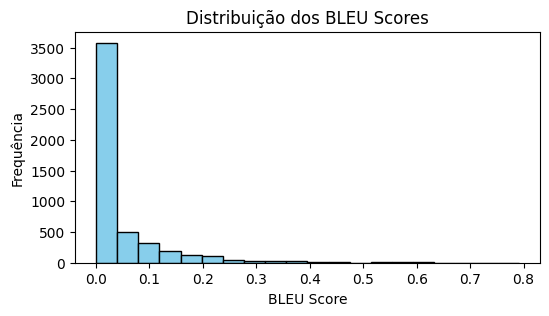

In [86]:
# Histograma dos BLEU scores
plt.figure(figsize=(6, 3))
plt.hist(test_dataset['BLEU Score'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribuição dos BLEU Scores')
plt.xlabel('BLEU Score')
plt.ylabel('Frequência')
plt.show()

### Análise de erros

In [87]:
# Filtrar respostas com BLEU score abaixo de um determinado limiar (por exemplo, 0.2)
low_bleu_responses = test_dataset[test_dataset['BLEU Score'] < 0.2]

# Visualizar um exemplo de respostas com BLEU scores baixos para identificar padrões
low_bleu_responses[['instruction', 'input', 'output', 'predicted_output', 'BLEU Score']]

,instruction,input,output,predicted_output,BLEU Score
5000,Generate a chessboard with the given size and ...,Size: 8x8 \nPiece positions:\nWhite Rook at H8...,![Image of 8x8 chessboard](https://i.imgur.com...,Generate a chessboard with the given size and ...,0.000341
5001,Find a word in the sentence that is used as a ...,Sentence: She went to the store to buy some ap...,Store.,Find a word in the sentence that is used as a ...,0.000000
5002,Write pseudocode for a Merge Sort algorithm.,,"MergeSort(A, startIndex, endIndex):\n // If...",Write pseudocode for a Merge Sort algorithm.\n...,0.005349
5003,Provide a evidence explaining why the followin...,"def add(a, b):\n return a + b",The code above is incorrect because it does no...,Provide a evidence explaining why the followin...,0.131717
5004,Compare and contrast Object-Oriented Programmi...,,Object-oriented programming (OOP) and function...,Compare and contrast Object-Oriented Programmi...,0.029357
...,...,...,...,...,...
9994,Generate a list of four interesting facts abou...,,1. The Amazon rainforest is a large tropical r...,Generate a list of four interesting facts abou...,0.119613
9995,Summarize the main points of a news article ab...,,The 2020 US Presidential election was one of t...,Summarize the main points of a news article ab...,0.036593
9996,Edit the following sentence for a more academi...,,Computers are immensely powerful due to their ...,Edit the following sentence for a more academi...,0.023372
9997,Name five common agile software development pr...,,Five common agile software development process...,Name five common agile software development pr...,0.029766


In [96]:
# Função para categorizar as respostas
def categorizar_erro(row):
    # Considera "Resposta Correta" se o BLEU score for acima de um limiar, por exemplo, 0.5
    if row['BLEU Score'] >= 0.5:
        return "Resposta Correta"
    elif "some specific condition indicating misinterpretation" in row['predicted_output']:
        return "Malinterpretação da Instrução"
    elif len(row['predicted_output'].split()) < len(row['output'].split()) * 0.5:  # Exemplo de resposta incompleta
        return "Resposta Incompleta"
    else:
        return "Geração Incoerente"

# Aplicar a função ao conjunto de respostas com BLEU scores
test_dataset['Categoria de Erro'] = test_dataset.apply(categorizar_erro, axis=1)

# Ver as categorias de erro
test_dataset[['instruction', 'input', 'output', 'predicted_output', 'BLEU Score', 'Categoria de Erro']]

/tmp/ipykernel_7786/1625506214.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_dataset['Categoria de Erro'] = test_dataset.apply(categorizar_erro, axis=1)


,instruction,input,output,predicted_output,BLEU Score,Categoria de Erro
5000,Generate a chessboard with the given size and ...,Size: 8x8 \nPiece positions:\nWhite Rook at H8...,![Image of 8x8 chessboard](https://i.imgur.com...,Generate a chessboard with the given size and ...,0.000341,Geração Incoerente
5001,Find a word in the sentence that is used as a ...,Sentence: She went to the store to buy some ap...,Store.,Find a word in the sentence that is used as a ...,0.000000,Geração Incoerente
5002,Write pseudocode for a Merge Sort algorithm.,,"MergeSort(A, startIndex, endIndex):\n // If...",Write pseudocode for a Merge Sort algorithm.\n...,0.005349,Resposta Incompleta
5003,Provide a evidence explaining why the followin...,"def add(a, b):\n return a + b",The code above is incorrect because it does no...,Provide a evidence explaining why the followin...,0.131717,Geração Incoerente
5004,Compare and contrast Object-Oriented Programmi...,,Object-oriented programming (OOP) and function...,Compare and contrast Object-Oriented Programmi...,0.029357,Geração Incoerente
...,...,...,...,...,...,...
9995,Summarize the main points of a news article ab...,,The 2020 US Presidential election was one of t...,Summarize the main points of a news article ab...,0.036593,Geração Incoerente
9996,Edit the following sentence for a more academi...,,Computers are immensely powerful due to their ...,Edit the following sentence for a more academi...,0.023372,Geração Incoerente
9997,Name five common agile software development pr...,,Five common agile software development process...,Name five common agile software development pr...,0.029766,Geração Incoerente
9998,What is the full name of the Euro currency?,,The full name of the Euro currency is the Euro...,What is the full name of the Euro currency?\nT...,0.401577,Geração Incoerente


In [100]:
#Quadro comparativo entre as respostas esperadas e as geradas
comparacao = test_dataset[['instruction', 'input', 'output', 'predicted_output']]
comparacao.head(5)

,instruction,input,output,predicted_output
5000,Generate a chessboard with the given size and ...,Size: 8x8 \nPiece positions:\nWhite Rook at H8...,![Image of 8x8 chessboard](https://i.imgur.com...,Generate a chessboard with the given size and ...
5001,Find a word in the sentence that is used as a ...,Sentence: She went to the store to buy some ap...,Store.,Find a word in the sentence that is used as a ...
5002,Write pseudocode for a Merge Sort algorithm.,,"MergeSort(A, startIndex, endIndex):\n // If...",Write pseudocode for a Merge Sort algorithm.\n...
5003,Provide a evidence explaining why the followin...,"def add(a, b):\n return a + b",The code above is incorrect because it does no...,Provide a evidence explaining why the followin...
5004,Compare and contrast Object-Oriented Programmi...,,Object-oriented programming (OOP) and function...,Compare and contrast Object-Oriented Programmi...


In [98]:
# Resumo das categorias de erro
error_summary = test_dataset['Categoria de Erro'].value_counts()
print("Resumo das Categorias de Erro:")
print(error_summary)

Resumo das Categorias de Erro:
Categoria de Erro
Geração Incoerente     4890
Resposta Incompleta      89
Resposta Correta         21
Name: count, dtype: int64


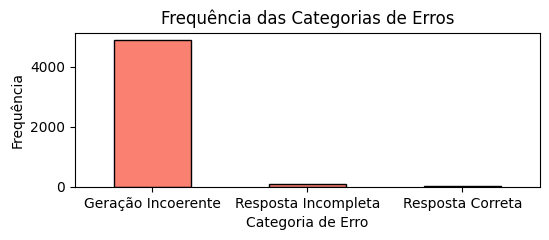

In [99]:
# Gráfico de barras da Frequência das Categorias de Erros
plt.figure(figsize=(6, 2))
ax = error_summary.plot(kind='bar', color='salmon', edgecolor='black')
plt.title('Frequência das Categorias de Erros')
plt.xlabel('Categoria de Erro')
plt.ylabel('Frequência')
plt.xticks(rotation=0)
plt.show()

Usando o BLEU score como métrica para indicar o limiar >0.5 para determinar se as respostas são corretas ou não, observamos que apenas 21 respostas caem na categoria de corretas, o que indica um acerto muito baixo.

# Métodos que podem ser usados para melhorá-las.

**Para melhorar o desempenho do modelo, podemos considerar diversos métodos adicionais. Um deles é o fine-tuning, ajustar os prompts usados para guiar o modelo, tornando-os mais claros e específicos para reduzir ambiguidades e mal-entendidos. Também podemos explorar técnicas de data augmentation, onde os dados de treinamento são aumentados com variações que podem ajudar o modelo a generalizar melhor.** 

In [156]:
cd ..

/home/insightlab/Documents/Axur


/home/insightlab/.local/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [157]:
test_dataset.to_csv("test_datasetT1.csv", index=False)

In [7]:
test_dataset = pd.read_csv('test_datasetT1.csv')

# Fine-Tuning, ajustando um conjunto menor de parâmetros e consumindo menos memória.

In [ ]:
!pip install --upgrade bitsandbytes transformers peft accelerate datasets trl
#!pip install tf-keras
#!pip install tensorflow==2.11
#!pip install --upgrade transformers
#!pip install accelerate
#pip install --upgrade transformers peft accelerate torch

In [7]:
import os
os.cpu_count()

16

In [5]:
import numpy as np
import contextlib
from datasets import load_dataset
from peft import LoraConfig, get_peft_model, PeftModel, prepare_model_for_kbit_training
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig, AutoModel,
    AutoTokenizer,
    TrainingArguments,
)
from trl import SFTTrainer
from accelerate import Accelerator, init_empty_weights, dispatch_model, infer_auto_device_map


2024-08-22 19:31:46.309328: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-22 19:31:46.320848: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-22 19:31:46.324388: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-22 19:31:46.333760: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-22 19:31:47.062282: W tensorflow/compiler/tf2

In [7]:
train_dataset

,instruction,input,output,text
0,Give three tips for staying healthy.,,1.Eat a balanced diet and make sure to include...,Below is an instruction that describes a task....
1,What are the three primary colors?,,"The three primary colors are red, blue, and ye...",Below is an instruction that describes a task....
2,Describe the structure of an atom.,,"An atom is made up of a nucleus, which contain...",Below is an instruction that describes a task....
3,How can we reduce air pollution?,,There are a number of ways to reduce air pollu...,Below is an instruction that describes a task....
4,Describe a time when you had to make a difficu...,,I had to make a difficult decision when I was ...,Below is an instruction that describes a task....
...,...,...,...,...
4995,Generate a song using the following context an...,Context: A love song\nMelody:,Verse 1\nWhen I saw you in the room\nMy heart ...,"Below is an instruction that describes a task,..."
4996,Automatically generate a design given the foll...,Description: An abstract flower pattern\nColor...,![Image of abstract flower pattern](https://i....,"Below is an instruction that describes a task,..."
4997,Automatically generate a logo given the follow...,Business Name: Awesome Cafe\nDesign Guidelines...,![Image of Awesome Cafe logo](https://i.imgur....,"Below is an instruction that describes a task,..."
4998,Generate a valid HTML page given the following...,Header: Welcome to My Website\nContent: \nThis...,<!DOCTYPE html>\n<html>\n <head>\n <tit...,"Below is an instruction that describes a task,..."


Usando [QLoRa: Fine-Tune a Large Language Model on Your GPU](https://kaitchup.substack.com/p/qlora-fine-tune-a-large-language-model-on-your-gpu-27bed5a03e2b)

In [6]:
torch.cuda.empty_cache()
gc.collect()

20

In [9]:
# Carregar o modelo e o tokenizer
model_name = "Qwen/Qwen1.5-1.8B"
tokenizer = AutoTokenizer.from_pretrained(model_name, add_eos_token=True, use_fast=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.padding_side = 'left'

### Quantização (Quantization)

A quantização em 4 bits **(bnb_4bit)** reduz a precisão dos pesos do modelo, o que diminui a quantidade de memória necessária e acelera o treinamento. Essa abordagem permite que o modelo seja treinado em GPUs com menos memória e ajuda a ajustar um conjunto menor de parâmetros com precisão reduzida, sem sacrificar muito o desempenho.

In [10]:
# Quantização em 4 bits - Definir bnb_config corretamente
compute_dtype = getattr(torch, "float16")
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=True,
)

In [11]:
if torch.cuda.is_available():
    # Verificar a capacidade da GPU para operações FP16
    print(f"Nome da GPU: {torch.cuda.get_device_name(0)}")
    print(f"Suporte a Float16 (FP16): {torch.cuda.get_device_capability(0)}")
else:
    print("CUDA não está disponível. Não há suporte para operações FP16.")

print(f"Número de GPUs disponíveis: {torch.cuda.device_count()}")

Nome da GPU: NVIDIA GeForce RTX 3060
Suporte a Float16 (FP16): (8, 6)
Número de GPUs disponíveis: 1


In [12]:
try:
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        quantization_config=bnb_config, #reducir o número de bits usados

        #device_map="auto",
        device_map={"": 0},           # distribuir na GPU 0

        # Testando com 'torch.float16' - ocupa metade da memória e permite realizar operações mais rápidas em GPUs que suportam este tipo de dado.
        # Mais pode levar a perda de informações em cálculos numéricos, resultando em underflow ou overflow
        torch_dtype=torch.float16,
        #torch_dtype="auto", #permite que o PyTorch e o Hugging Face determinem automaticamente o tipo de dado mais apropriado com base no hardware disponível (como GPU ou CPU) e na configuração do modelo.

        low_cpu_mem_usage=True, # Reduz o uso de memória na CPU durante o carregamento do modelo
    )
    print("Modelo carregado com sucesso.")
except Exception as e:
    print("Erro ao carregar o modelo:", str(e))

Modelo carregado com sucesso.


In [13]:
# Configurar o token pad no modelo
model.config.pad_token_id = tokenizer.pad_token_id
model.config.use_cache = False  # Gradient checkpointing é usado por padrão mas não é compatível com caching

In [14]:
# Contar o número de camadas de transformadores (geralmente nomeadas como 'layer' ou 'block')
transformer_layer_count = 0

for name, module in model.named_modules():
    if 'layer' in name:  # Dependendo do modelo, pode ser 'block', 'encoder.layer', etc.
        transformer_layer_count += 1

print(f"O modelo tem {transformer_layer_count} camadas de transformador.")

O modelo tem 337 camadas de transformador.


In [15]:
# Listar os nomes das camadas e parâmetros do modelo
for name, param in model.named_parameters():
    print(name)

model.embed_tokens.weight
model.layers.0.self_attn.q_proj.weight
model.layers.0.self_attn.q_proj.bias
model.layers.0.self_attn.k_proj.weight
model.layers.0.self_attn.k_proj.bias
model.layers.0.self_attn.v_proj.weight
model.layers.0.self_attn.v_proj.bias
model.layers.0.self_attn.o_proj.weight
model.layers.0.mlp.gate_proj.weight
model.layers.0.mlp.up_proj.weight
model.layers.0.mlp.down_proj.weight
model.layers.0.input_layernorm.weight
model.layers.0.post_attention_layernorm.weight
model.layers.1.self_attn.q_proj.weight
model.layers.1.self_attn.q_proj.bias
model.layers.1.self_attn.k_proj.weight
model.layers.1.self_attn.k_proj.bias
model.layers.1.self_attn.v_proj.weight
model.layers.1.self_attn.v_proj.bias
model.layers.1.self_attn.o_proj.weight
model.layers.1.mlp.gate_proj.weight
model.layers.1.mlp.up_proj.weight
model.layers.1.mlp.down_proj.weight
model.layers.1.input_layernorm.weight
model.layers.1.post_attention_layernorm.weight
model.layers.2.self_attn.q_proj.weight
model.layers.2.self

In [16]:
#M7
for name, param in model.named_parameters():
    if 'base_model.model.model.layers' in name:  # Identificar camadas do transformador
        if not 'layers.23' in name:  # Congelar todas as camadas, exceto a última
            param.requires_grad = False  # Congela essas camadas
        else:
            # Verificar se o tensor é de ponto flutuante antes de ajustar requires_grad
            if param.dtype in [torch.float16, torch.float32, torch.float64]:
                param.requires_grad = True  # Descongela a última camada
    else:
        # Verificar se o tensor é de ponto flutuante antes de ajustar requires_grad
        if param.dtype in [torch.float16, torch.float32, torch.float64]:
            param.requires_grad = True  # Descongela camadas fora do transformador, como norm e lm_head


In [17]:
# Contadores para as camadas congeladas e não congeladas
total_params = 0
frozen_params = 0
trainable_params = 0

# Verificar se a configuração foi aplicada corretamente
for name, param in model.named_parameters():
    if param.requires_grad:
        trainable_params += 1
        print(f"Treinável: {name}")
    else:
        frozen_params += 1
        print(f"Congelado: {name}")
    total_params += 1

print(f"Total de parâmetros: {total_params}")
print(f"Parâmetros congelados: {frozen_params}")
print(f"Parâmetros treináveis: {trainable_params}")

Treinável: model.embed_tokens.weight
Congelado: model.layers.0.self_attn.q_proj.weight
Treinável: model.layers.0.self_attn.q_proj.bias
Congelado: model.layers.0.self_attn.k_proj.weight
Treinável: model.layers.0.self_attn.k_proj.bias
Congelado: model.layers.0.self_attn.v_proj.weight
Treinável: model.layers.0.self_attn.v_proj.bias
Congelado: model.layers.0.self_attn.o_proj.weight
Congelado: model.layers.0.mlp.gate_proj.weight
Congelado: model.layers.0.mlp.up_proj.weight
Congelado: model.layers.0.mlp.down_proj.weight
Treinável: model.layers.0.input_layernorm.weight
Treinável: model.layers.0.post_attention_layernorm.weight
Congelado: model.layers.1.self_attn.q_proj.weight
Treinável: model.layers.1.self_attn.q_proj.bias
Congelado: model.layers.1.self_attn.k_proj.weight
Treinável: model.layers.1.self_attn.k_proj.bias
Congelado: model.layers.1.self_attn.v_proj.weight
Treinável: model.layers.1.self_attn.v_proj.bias
Congelado: model.layers.1.self_attn.o_proj.weight
Congelado: model.layers.1.mlp

In [18]:
# Verificar a última camada específica
for name, param in model.named_parameters():
    if 'layers.23' in name:  # Supondo que 'layers.23' seja a última camada
        if param.requires_grad:
            print(f"A última camada {name} é treinável (correto).")
        else:
            print(f"A última camada {name} está congelada (erro).")
    else:
        if not param.requires_grad:
            print(f"Camada {name} corretamente congelada.")

Camada model.layers.0.self_attn.q_proj.weight corretamente congelada.
Camada model.layers.0.self_attn.k_proj.weight corretamente congelada.
Camada model.layers.0.self_attn.v_proj.weight corretamente congelada.
Camada model.layers.0.self_attn.o_proj.weight corretamente congelada.
Camada model.layers.0.mlp.gate_proj.weight corretamente congelada.
Camada model.layers.0.mlp.up_proj.weight corretamente congelada.
Camada model.layers.0.mlp.down_proj.weight corretamente congelada.
Camada model.layers.1.self_attn.q_proj.weight corretamente congelada.
Camada model.layers.1.self_attn.k_proj.weight corretamente congelada.
Camada model.layers.1.self_attn.v_proj.weight corretamente congelada.
Camada model.layers.1.self_attn.o_proj.weight corretamente congelada.
Camada model.layers.1.mlp.gate_proj.weight corretamente congelada.
Camada model.layers.1.mlp.up_proj.weight corretamente congelada.
Camada model.layers.1.mlp.down_proj.weight corretamente congelada.
Camada model.layers.2.self_attn.q_proj.wei

### LoRA (Low-Rank Adaptation)

Estamos ajustando apenas algumas camadas específicas do modelo, conforme definido na configuração LoraConfig.

No código, as camadas **['k_proj', 'q_proj', 'v_proj', 'o_proj', "gate_proj", "down_proj", "up_proj"]** são as que serão ajustadas.

Essas camadas são as projeções de chave **(k_proj)**, consulta **(q_proj)**, valor **(v_proj)**, e outras projeções dentro do transformador, que são componentes críticos para a operação do modelo, mas ajustá-las de forma eficiente com LoRA reduz a quantidade de parâmetros que precisam ser treinados.

In [19]:
# Configuração LoRA
peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.05,
    r=16,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=['k_proj', 'q_proj', 'v_proj', 'o_proj', "gate_proj", "down_proj", "up_proj"]
)

In [20]:
# Aplicar PEFT ao modelo
model = get_peft_model(model, peft_config)

In [21]:
# Preparar o dataset de treino
train_texts = [f"{row['instruction']} {row['input']}" for _, row in train_dataset.iterrows()]
train_labels = [row['output'] for _, row in train_dataset.iterrows()]

In [22]:
# Transformar o DataFrame existente em um dataset customizado
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        inputs = self.tokenizer(self.texts[idx], padding='max_length', truncation=True, max_length=512, return_tensors="pt")
        labels = self.tokenizer(self.labels[idx], padding='max_length', truncation=True, max_length=512, return_tensors="pt")['input_ids']
        inputs['labels'] = labels
        return {key: val.squeeze(0) for key, val in inputs.items()}

In [23]:
# Criar o dataset
train_dataset = CustomDataset(train_texts, train_labels, tokenizer)

In [24]:
# Configurações de treinamento
training_arguments = TrainingArguments(
    output_dir="./results_qlora",
    weight_decay=0.01,  # Regularização L2 - A regularização ajuda a evitar overfitting, penalizando pesos muito grandes no modelo. Isso pode resultar em uma perda mais alta inicialmente, mas melhor desempenho em generalização.
    #evaluation_strategy="steps",
    evaluation_strategy="no",  # Desativar avaliação
    do_eval=False,  # Não fazer avaliação
    optim="paged_adamw_8bit",
    per_device_train_batch_size=2, #batch
    #per_device_eval_batch_size=4,
    #eval_steps=50,
    gradient_accumulation_steps=4,  # Acumula gradientes por 4 batches, equivalente a batch_size 4
    log_level="debug",
    save_steps=50,
    logging_steps=50,
    learning_rate=2e-5,  #2e-5, 1e-5
    num_train_epochs=50,  # Definir o número de épocas
    max_steps=300,
    warmup_steps=30,
    lr_scheduler_type="cosine",  # taxa de aprendizado como cosine, linear, ou exponential
    fp16=True,  # Habilitar FP16 para usar Float16 na GPU
    dataloader_num_workers=os.cpu_count()
)

/home/insightlab/.local/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


O fine-tuning foi aplicado utilizando diferentes configurações de parâmetros:

*   **Modelo 1:** Treinado por 10 épocas com uma taxa de aprendizado linear.
*   **Modelo 2:** Aumentou-se para 50 épocas, aplicou-se uma taxa de aprendizado cossenoide, e a regularização L2 foi elevada para 0.01, o que ajuda a evitar overfitting penalizando pesos excessivamente grandes. Essa configuração pode resultar em uma perda mais alta inicialmente, mas proporciona melhor desempenho em termos de generalização.
*   **Modelo 3:** Treinado por 50 épocas com taxa de aprendizado cossenoide, regularização L2 de 0.01, e a taxa de aprendizado foi reduzida de 2e-5 para 1e-5, visando ajustes mais precisos.
*   **Modelo 4:** Treinado por 50 épocas com taxa de aprendizado cossenoide, mantendo a taxa de aprendizado em 1e-5, mas aumentando a penalidade sobre os pesos para 0.05.
*   **Modelo 5:** Configuração semelhante ao Modelo 4, mas com a redução da regularização L2 para 0.001, diminuindo o efeito da penalidade sobre os pesos.
*   **Modelo 6:** Configuração semelhante ao Modelo 5, mas taxa de aprendizado em 2e-5.

In [25]:
# Inicializar o Trainer com PEFT (LoRA)
trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset,
    peft_config=peft_config,
    dataset_text_field="text",
    max_seq_length=128,         # 512 - 256 - 128 - Limite para as sequências de entrada e saída
    tokenizer=tokenizer,
    args=training_arguments,
)

/home/insightlab/.local/lib/python3.10/site-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': dataset_text_field, max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/home/insightlab/.local/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/home/insightlab/.local/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
/home/insightlab/.local/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:318: UserWarning: You passed a `dataset_text_field` argume

In [26]:
# Expandir Segmentos de Memória CUDA

os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

#terminal
#export PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True

In [27]:
torch.cuda.empty_cache()
gc.collect()
# Executar o treinamento (fine-tuning)
log_file_path = "fine_tuning_training_log.txt"
with open(log_file_path, "w") as log_file:
    with contextlib.redirect_stdout(log_file), contextlib.redirect_stderr(log_file):
        trainer.train()

Currently training with a batch size of: 2
***** Running training *****
  Num examples = 5,000
  Num Epochs = 1
  Instantaneous batch size per device = 2
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 4
  Total optimization steps = 300
  Number of trainable parameters = 14,991,360
Saving model checkpoint to ./results_qlora/checkpoint-50
loading configuration file config.json from cache at /home/insightlab/.cache/huggingface/hub/models--Qwen--Qwen1.5-1.8B/snapshots/7846de7ed421727b318d6605a0bfab659da2c067/config.json
Model config Qwen2Config {
  "architectures": [
    "Qwen2ForCausalLM"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 151643,
  "eos_token_id": 151643,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 5504,
  "max_position_embeddings": 32768,
  "max_window_layers": 21,
  "model_type": "qwen2",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "num_key_value_

In [28]:
# Salvar o modelo ajustado
trainer.save_model("./fine_tuned_model_7")

Saving model checkpoint to ./fine_tuned_model_7
loading configuration file config.json from cache at /home/insightlab/.cache/huggingface/hub/models--Qwen--Qwen1.5-1.8B/snapshots/7846de7ed421727b318d6605a0bfab659da2c067/config.json
Model config Qwen2Config {
  "architectures": [
    "Qwen2ForCausalLM"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 151643,
  "eos_token_id": 151643,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 5504,
  "max_position_embeddings": 32768,
  "max_window_layers": 21,
  "model_type": "qwen2",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "num_key_value_heads": 16,
  "rms_norm_eps": 1e-06,
  "rope_theta": 1000000.0,
  "sliding_window": null,
  "tie_word_embeddings": false,
  "torch_dtype": "bfloat16",
  "transformers_version": "4.44.1",
  "use_cache": true,
  "use_sliding_window": false,
  "vocab_size": 151936
}

tokenizer config file saved in ./fine_tuned_model_7/tokenizer_config.json
Special 

In [29]:
# Acessar o histórico de logs
log_history = trainer.state.log_history

# Exibir as últimas entradas de log para verificar a perda final
print(log_history[-10:])  # Mostra as últimas 10 entradas

[{'loss': 3.3091, 'grad_norm': 5.555326461791992, 'learning_rate': 1.9848077530122083e-05, 'epoch': 0.08, 'step': 50}, {'loss': 2.7252, 'grad_norm': 2.5027596950531006, 'learning_rate': 1.7273736415730488e-05, 'epoch': 0.16, 'step': 100}, {'loss': 2.4597, 'grad_norm': 2.4175806045532227, 'learning_rate': 1.2306158707424402e-05, 'epoch': 0.24, 'step': 150}, {'loss': 2.3909, 'grad_norm': 1.8559324741363525, 'learning_rate': 6.579798566743314e-06, 'epoch': 0.32, 'step': 200}, {'loss': 2.2804, 'grad_norm': 2.6935319900512695, 'learning_rate': 1.9787680724495617e-06, 'epoch': 0.4, 'step': 250}, {'loss': 2.3286, 'grad_norm': 3.0507071018218994, 'learning_rate': 1.6918417287318245e-08, 'epoch': 0.48, 'step': 300}, {'train_runtime': 731.2381, 'train_samples_per_second': 3.282, 'train_steps_per_second': 0.41, 'total_flos': 1.13589419507712e+16, 'train_loss': 2.582320098876953, 'epoch': 0.48, 'step': 300}]


In [30]:
def save_loss_log(trainer, model_name, file_path="loss.csv"):
    # Acessar o histórico de logs
    log_history = trainer.state.log_history

    # Filtrar as entradas que possuem a chave 'loss'
    loss_logs = [entry for entry in log_history if 'loss' in entry]

    # Criar um DataFrame a partir dos logs de perda
    df_new_loss = pd.DataFrame(loss_logs)

    # Adicionar uma nova coluna para identificar o modelo
    df_new_loss['model'] = model_name

    # Verificar se o arquivo já existe
    if os.path.exists(file_path):
        # Ler o arquivo existente
        df_existing_loss = pd.read_csv(file_path)

        # Concatenar os novos dados com os dados existentes
        df_combined_loss = pd.concat([df_existing_loss, df_new_loss], ignore_index=True)
    else:
        # Se o arquivo não existir, use apenas os novos dados
        df_combined_loss = df_new_loss

    # Salvar o DataFrame combinado no arquivo CSV
    df_combined_loss.to_csv(file_path, index=False)

    print(f"Log de perda salvo em {file_path}")

    return df_combined_loss

# Exemplo de uso da função
df_loss = save_loss_log(trainer, model_name='Modelo_7')
df_loss

Log de perda salvo em loss.csv


,loss,grad_norm,learning_rate,epoch,step,model
0,3.3197,5.049464,1.896296e-05,0.08,50,Modelo_1
1,2.7492,3.218431,1.525926e-05,0.16,100,Modelo_1
2,2.4859,2.488843,1.155556e-05,0.24,150,Modelo_1
3,2.4086,1.832678,7.851852e-06,0.32,200,Modelo_1
4,2.2929,2.434949,4.148148e-06,0.40,250,Modelo_1
5,2.3306,3.031722,4.444444e-07,0.48,300,Modelo_1
6,3.3070,5.425925,1.984808e-05,0.08,50,Modelo_2
7,2.7047,2.601022,1.727374e-05,0.16,100,Modelo_2
8,2.4563,2.406001,1.230616e-05,0.24,150,Modelo_2
9,2.3901,1.969653,6.579799e-06,0.32,200,Modelo_2


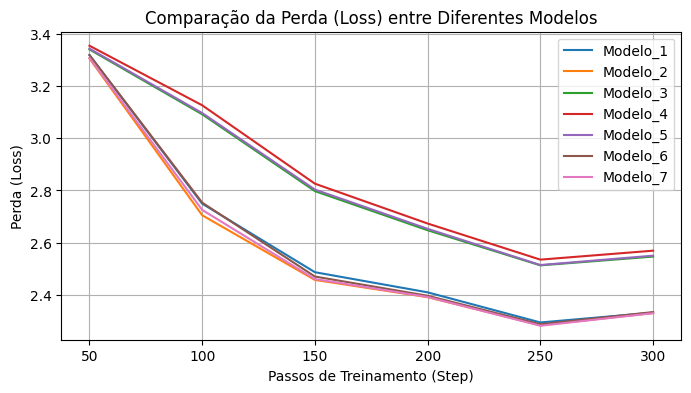

In [31]:
# Plotar as perdas de diferentes modelos
plt.figure(figsize=(8, 4))

for model_name in df_loss['model'].unique():
    df_model = df_loss[df_loss['model'] == model_name]
    plt.plot(df_model['step'], df_model['loss'], label=model_name)

plt.xlabel('Passos de Treinamento (Step)')
plt.ylabel('Perda (Loss)')
plt.title('Comparação da Perda (Loss) entre Diferentes Modelos')
plt.legend()
plt.grid(True)
plt.show()

Até agora, realizamos o fine-tuning do modelo Qwen/Qwen1.5-1.8B utilizando uma abordagem progressivamente mais eficiente. Inicialmente, ajustamos todos os parâmetros do modelo (modelos do 1 ao 6), mas depois optamos por congelar todas as camadas do transformador, exceto a última (modelo 7), para focar o ajuste apenas nas partes mais relevantes para a nova tarefa. Essa estratégia preserva o conhecimento pré-treinado nas camadas anteriores, economiza recursos computacionais e minimiza o risco de overfitting. Além disso, utilizamos técnicas avançadas como LoRA (Low-Rank Adaptation), que permite ajustar apenas subcomponentes específicos, como projeções de atenção e MLP, em vez de todo o modelo, e aplicamos quantização em 4 bits para reduzir o consumo de memória. Com essas abordagens, realizamos o fine-tuning de forma eficiente, concentrando os ajustes nas partes mais críticas do modelo, mantendo a estabilidade e acelerando o treinamento.

# Execução do dataset de teste nas instruções da coluna "instruction" com o modelo onde foi aplicado fine-tuning.

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from sklearn.metrics import precision_score, recall_score, f1_score

In [5]:
test_dataset

,instruction,input,output,text
5000,Generate a chessboard with the given size and ...,Size: 8x8 \nPiece positions:\nWhite Rook at H8...,![Image of 8x8 chessboard](https://i.imgur.com...,"Below is an instruction that describes a task,..."
5001,Find a word in the sentence that is used as a ...,Sentence: She went to the store to buy some ap...,Store.,"Below is an instruction that describes a task,..."
5002,Write pseudocode for a Merge Sort algorithm.,,"MergeSort(A, startIndex, endIndex):\n // If...",Below is an instruction that describes a task....
5003,Provide a evidence explaining why the followin...,"def add(a, b):\n return a + b",The code above is incorrect because it does no...,"Below is an instruction that describes a task,..."
5004,Compare and contrast Object-Oriented Programmi...,,Object-oriented programming (OOP) and function...,Below is an instruction that describes a task....
...,...,...,...,...
9995,Summarize the main points of a news article ab...,,The 2020 US Presidential election was one of t...,Below is an instruction that describes a task....
9996,Edit the following sentence for a more academi...,,Computers are immensely powerful due to their ...,Below is an instruction that describes a task....
9997,Name five common agile software development pr...,,Five common agile software development process...,Below is an instruction that describes a task....
9998,What is the full name of the Euro currency?,,The full name of the Euro currency is the Euro...,Below is an instruction that describes a task....


In [6]:
model_path = "./fine_tuned_model_7"

# Carregar o tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_path)

# Carregar o modelo treinado (adaptado) a partir dos arquivos
model = AutoModelForCausalLM.from_pretrained(model_path)

# Certifique-se de mover o modelo para a GPU se disponível
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 2048)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2SdpaAttention(
          (q_proj): lora.Linear(
            (base_layer): Linear(in_features=2048, out_features=2048, bias=True)
            (lora_dropout): ModuleDict(
              (default): Dropout(p=0.05, inplace=False)
            )
            (lora_A): ModuleDict(
              (default): Linear(in_features=2048, out_features=16, bias=False)
            )
            (lora_B): ModuleDict(
              (default): Linear(in_features=16, out_features=2048, bias=False)
            )
            (lora_embedding_A): ParameterDict()
            (lora_embedding_B): ParameterDict()
            (lora_magnitude_vector): ModuleDict()
          )
          (k_proj): lora.Linear(
            (base_layer): Linear(in_features=2048, out_features=2048, bias=True)
            (lora_dropout): ModuleDict(
              (defau

In [7]:
# Função para gerar uma resposta usando o modelo ajustado
def generate_response_qwen(instruction, input_text):
    prompt = f"{instruction}\n{input_text}"
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    
    with torch.no_grad():
        outputs = model.generate(**inputs, max_length=150)
    
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return response

# Aplicar o modelo ao conjunto de teste
test_dataset['predicted_output'] = test_dataset.apply(
    lambda row: generate_response_qwen(row['instruction'], row['input']), axis=1)

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Both `max_new_tokens` (=2048) and `max_length`(=150) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Both `max_new_tokens` (=2048) and `max_length`(=150) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Both `max_new_tokens` (=2048) and `max_length`(=150) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `e

In [8]:
test_dataset.to_csv("test_datasetT2.csv", index=False)

In [9]:
test_datasetT2 = test_dataset

# Resultados comparados no teste dos dois modelos.

In [10]:
test_datasetT2

,instruction,input,output,text,predicted_output
5000,Generate a chessboard with the given size and ...,Size: 8x8 \nPiece positions:\nWhite Rook at H8...,![Image of 8x8 chessboard](https://i.imgur.com...,"Below is an instruction that describes a task,...",Generate a chessboard with the given size and ...
5001,Find a word in the sentence that is used as a ...,Sentence: She went to the store to buy some ap...,Store.,"Below is an instruction that describes a task,...",Find a word in the sentence that is used as a ...
5002,Write pseudocode for a Merge Sort algorithm.,,"MergeSort(A, startIndex, endIndex):\n // If...",Below is an instruction that describes a task....,Write pseudocode for a Merge Sort algorithm.\n...
5003,Provide a evidence explaining why the followin...,"def add(a, b):\n return a + b",The code above is incorrect because it does no...,"Below is an instruction that describes a task,...",Provide a evidence explaining why the followin...
5004,Compare and contrast Object-Oriented Programmi...,,Object-oriented programming (OOP) and function...,Below is an instruction that describes a task....,Compare and contrast Object-Oriented Programmi...
...,...,...,...,...,...
9995,Summarize the main points of a news article ab...,,The 2020 US Presidential election was one of t...,Below is an instruction that describes a task....,Summarize the main points of a news article ab...
9996,Edit the following sentence for a more academi...,,Computers are immensely powerful due to their ...,Below is an instruction that describes a task....,Edit the following sentence for a more academi...
9997,Name five common agile software development pr...,,Five common agile software development process...,Below is an instruction that describes a task....,Name five common agile software development pr...
9998,What is the full name of the Euro currency?,,The full name of the Euro currency is the Euro...,Below is an instruction that describes a task....,What is the full name of the Euro currency?\nT...


In [17]:
test_resultsT1 = pd.read_csv("test_datasetT1.csv")
test_resultsT1

,instruction,input,output,text,predicted_output,BLEU Score,Categoria de Erro
0,Generate a chessboard with the given size and ...,Size: 8x8 \nPiece positions:\nWhite Rook at H8...,![Image of 8x8 chessboard](https://i.imgur.com...,"Below is an instruction that describes a task,...",Generate a chessboard with the given size and ...,0.000341,Geração Incoerente
1,Find a word in the sentence that is used as a ...,Sentence: She went to the store to buy some ap...,Store.,"Below is an instruction that describes a task,...",Find a word in the sentence that is used as a ...,0.000000,Geração Incoerente
2,Write pseudocode for a Merge Sort algorithm.,NaN,"MergeSort(A, startIndex, endIndex):\n // If...",Below is an instruction that describes a task....,Write pseudocode for a Merge Sort algorithm.\n...,0.005349,Resposta Incompleta
3,Provide a evidence explaining why the followin...,"def add(a, b):\n return a + b",The code above is incorrect because it does no...,"Below is an instruction that describes a task,...",Provide a evidence explaining why the followin...,0.131717,Geração Incoerente
4,Compare and contrast Object-Oriented Programmi...,NaN,Object-oriented programming (OOP) and function...,Below is an instruction that describes a task....,Compare and contrast Object-Oriented Programmi...,0.029357,Geração Incoerente
...,...,...,...,...,...,...,...
4995,Summarize the main points of a news article ab...,NaN,The 2020 US Presidential election was one of t...,Below is an instruction that describes a task....,Summarize the main points of a news article ab...,0.036593,Geração Incoerente
4996,Edit the following sentence for a more academi...,NaN,Computers are immensely powerful due to their ...,Below is an instruction that describes a task....,Edit the following sentence for a more academi...,0.023372,Geração Incoerente
4997,Name five common agile software development pr...,NaN,Five common agile software development process...,Below is an instruction that describes a task....,Name five common agile software development pr...,0.029766,Geração Incoerente
4998,What is the full name of the Euro currency?,NaN,The full name of the Euro currency is the Euro...,Below is an instruction that describes a task....,What is the full name of the Euro currency?\nT...,0.401577,Geração Incoerente


In [19]:
# Função para calcular o BLEU Score para uma única linha
def calculate_bleu_score(reference, hypothesis):
    # Se referência ou hipótese forem NaN, retornar zero
    if pd.isnull(reference) or pd.isnull(hypothesis):
        return 0.0
    reference_tokens = reference.strip().split()
    hypothesis_tokens = hypothesis.strip().split()
    smoothie = SmoothingFunction().method4  # Usar smoothing para evitar scores zero
    score = sentence_bleu([reference_tokens], hypothesis_tokens, smoothing_function=smoothie)
    return score

# Aplicar a função em todo o dataframe
test_datasetT2['BLEU Score'] = test_datasetT2.apply(lambda row: calculate_bleu_score(row['output'], row['predicted_output']), axis=1)

/tmp/ipykernel_5560/2947118315.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_datasetT2['BLEU Score'] = test_datasetT2.apply(lambda row: calculate_bleu_score(row['output'], row['predicted_output']), axis=1)


In [20]:
# categorias de erro
def categorizar_erro(row):
    # Considera "Resposta Correta" se o BLEU score for acima de um limiar, por exemplo, 0.5
    if row['BLEU Score'] >= 0.5:
        return "Resposta Correta"
    elif "some specific condition indicating misinterpretation" in row['predicted_output']:
        return "Malinterpretação da Instrução"
    elif len(row['predicted_output'].split()) < len(row['output'].split()) * 0.5:  # Exemplo de resposta incompleta
        return "Resposta Incompleta"
    else:
        return "Geração Incoerente"

# Aplicar a função ao conjunto de respostas com BLEU scores
test_datasetT2['Categoria de Erro'] = test_datasetT2.apply(categorizar_erro, axis=1)

/tmp/ipykernel_5560/3504346944.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_datasetT2['Categoria de Erro'] = test_datasetT2.apply(categorizar_erro, axis=1)


In [22]:
# Análise Estatística dos BLEU Scores

# Estatísticas descritivas para test_resultsT1
stats_t1 = test_resultsT1['BLEU Score'].describe()
print("Estatísticas do BLEU Score para test_resultsT1:")
print(stats_t1)

# Estatísticas descritivas para test_datasetT2
stats_t2 = test_datasetT2['BLEU Score'].describe()
print("\nEstatísticas do BLEU Score para test_datasetT2:")
print(stats_t2)

Estatísticas do BLEU Score para test_resultsT1:
count    5000.000000
mean        0.046034
std         0.081018
min         0.000000
25%         0.003404
50%         0.012450
75%         0.050523
max         0.790960
Name: BLEU Score, dtype: float64

Estatísticas do BLEU Score para test_datasetT2:
count    5000.000000
mean        0.033861
std         0.066992
min         0.000000
25%         0.001935
50%         0.007630
75%         0.031078
max         0.650770
Name: BLEU Score, dtype: float64


Os resultados da análise dos **BLEU Scores** para os conjuntos de teste da tarefa 1 e tarefa 2 indicam que a qualidade geral das respostas geradas pelos modelos é relativamente baixa, com médias de 0.046 e 0.034, o modelo frequentemente gera respostas que não correspondem bem às expectativas. No desvio padrão dos scores o teste 2  tem 0.067 mostrando variações, más ligeiramente menor do que o teste 1, sugerindo uma performance um pouco mais consistente, embora geralmente pior.

Comparando os dois conjuntos, o teste da tarefa 1 apresentou um desempenho um pouco melhor, mas ambos mostram que o modelo tem dificuldades consistentes, especialmente na geração de respostas coerentes e completas.

Pode ser necessário revisar a abordagem de fine-tuning, talvez utilizando mais dados de alta qualidade ou explorando diferentes técnicas de ajuste fino para melhorar a consistência e a qualidade das respostas geradas.

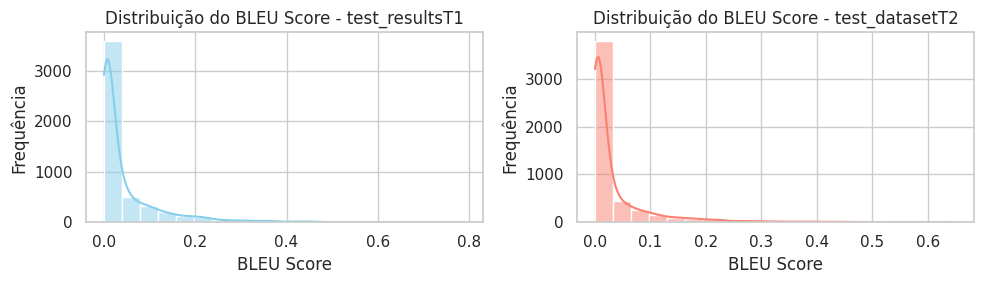

In [31]:
# Configurar o estilo dos plots
sns.set(style="whitegrid")

# Plotar histogramas lado a lado
plt.figure(figsize=(10, 3))

# Histograma para test_resultsT1
plt.subplot(1, 2, 1)
sns.histplot(test_resultsT1['BLEU Score'], bins=20, kde=True, color='skyblue')
plt.title('Distribuição do BLEU Score - test_resultsT1')
plt.xlabel('BLEU Score')
plt.ylabel('Frequência')

# Histograma para test_datasetT2
plt.subplot(1, 2, 2)
sns.histplot(test_datasetT2['BLEU Score'], bins=20, kde=True, color='salmon')
plt.title('Distribuição do BLEU Score - test_datasetT2')
plt.xlabel('BLEU Score')
plt.ylabel('Frequência')

plt.tight_layout()
plt.show()

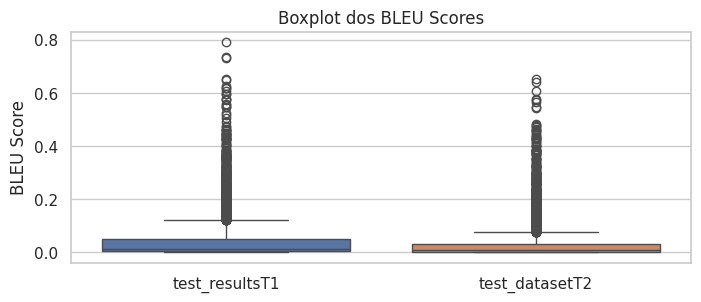

In [32]:
bleu_data = pd.DataFrame({
    'test_resultsT1': test_resultsT1['BLEU Score'],
    'test_datasetT2': test_datasetT2['BLEU Score']
})

# Plotar boxplots
plt.figure(figsize=(8, 3))
sns.boxplot(data=bleu_data)
plt.title('Boxplot dos BLEU Scores')
plt.ylabel('BLEU Score')
plt.show()

In [42]:
# Contagem das categorias de erro em test_resultsT1
error_counts_t1 = test_resultsT1['Categoria de Erro'].value_counts().reset_index()
error_counts_t1.columns = ['Categoria de Erro', 'Contagem']

# Contagem das categorias de erro em test_datasetT2
error_counts_t2 = test_datasetT2['Categoria de Erro'].value_counts().reset_index()
error_counts_t2.columns = ['Categoria de Erro', 'Contagem']

In [43]:
# Calcular percentual das categorias em test_resultsT1
error_percent_t1 = error_counts_t1.copy()
error_percent_t1['Percentual'] = (error_percent_t1['Contagem'] / error_percent_t1['Contagem'].sum()) * 100

# Calcular percentual das categorias em test_datasetT2
error_percent_t2 = error_counts_t2.copy()
error_percent_t2['Percentual'] = (error_percent_t2['Contagem'] / error_percent_t2['Contagem'].sum()) * 100

# Exibir os percentuais
print("Percentual das Categorias de Erro - test_resultsT1:")
display(error_percent_t1)

print("\nPercentual das Categorias de Erro - test_datasetT2:")
display(error_percent_t2)

Percentual das Categorias de Erro - test_resultsT1:


,Categoria de Erro,Contagem,Percentual
0,Geração Incoerente,4890,97.80
1,Resposta Incompleta,89,1.78
2,Resposta Correta,21,0.42



Percentual das Categorias de Erro - test_datasetT2:


,Categoria de Erro,Contagem,Percentual
0,Geração Incoerente,4950,99.00
1,Resposta Incompleta,42,0.84
2,Resposta Correta,8,0.16


Estos resultados reforçam a observação de que o modelo apresenta sérias dificuldades em gerar respostas coerentes e completas. A categoria "Geração Incoerente" domina amplamente em ambos os conjuntos, representando 97,8% em Teste da tarefa 1 e ainda mais, 99%, em teste da tarea 2. Indicando que a grande maioria das respostas geradas pelo modelo não faz sentido ou é irrelevante para a instrução dada.

A categoria "Resposta Incompleta" também está presente, mas com uma frequência muito menor, o que sugere que, mesmo quando o modelo tenta seguir a instrução, ele frequentemente falha em fornecer uma resposta completa.

A categoria "Resposta Correta" é extremamente rara, com apenas 0,42% e 0,16%, o que mostra que o modelo quase nunca acerta a resposta esperada.

Com estps resultados destaco uma vez mais que explorar novas intervenções no processo de fine-tuning e na estrutura do modelo permitiria melhorar significativamente a capacidade de seguir instruções de forma coerente e precisa.

# Como agrupar as perguntas que tratam de assuntos semelhantes nos dois datasets?

Para agrupar as perguntas que tratam de assuntos semelhantes nos dois datasets, seguiria uma abordagem utilizando técnicas de NLP e análise de similaridade textual. Primeiramente, removeria palavras comuns ("a, de, o, ou, etc."), aplicaria stemming para reduzir as palavras às suas formas básicas, converteria todo o texto em minúsculas e aplicaria vetorização das instruções com TF-IDF para adicionar um nível de importância às palavras. Também seria útil capturar o contexto semântico, medir a similaridade textual e trabalhar com clustering (a técnica depende muito do comportamento dos dados). Outras abordagens podem ser exploradas conforme os resultados dessas técnicas sejam analisados.